# **Lab Session : Feature selection I**


Author: Vanessa Gómez Verdejo (http://vanessa.webs.tsc.uc3m.es/)

Updated: 19/04/2017 (working with sklearn 0.18.1)

In this lab session we are going to study filtering methods for feature selection. To analyze their performances we will work with the Olivetti face detection problem. 

#### ** During this lab we will cover: **
#### *Part 1: Filter methods for feature selection* 
##### *   Part 1.1: F-score* 
##### *   Part 1.2: Mutual Information* 
##### *   Part 1.3: Random Forest* 
#### *Part 2: Advanced work:*
    1. HSIC 
    2. MRmr
#### *Part 3: More advanced work: search algorithms* 

To implement the different approaches we will base on [Scikit-Learn](http://scikit-learn.org/stable/) python toolbox.

As you progress in this notebook, you will have to complete some exercises. Each exercise includes an explanation of what is expected, followed by code cells where one or several lines will have written down `<FILL IN>`.  The cell that needs to be modified will have `# TODO: Replace <FILL IN> with appropriate code` on its first line.  Once the `<FILL IN>` sections are updated and the code can be run; below this cell, you will find the test cell (beginning with the line `# TEST CELL`) and you can run it to verify the correctness of your solution.  

In [1]:
%matplotlib inline

## ** Part 0: Download and prepare the data **

Olivetti dataset consists of ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).
    
The next code includes the lines to download this data set and create the training, validation and test data partitions, as well as normalize them.

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

np.random.seed(12)

def ReadEvents(file):
    data = np.loadtxt(file,skiprows=1,delimiter=';',usecols=range(0,37))
    labels = np.loadtxt(file,skiprows=1,delimiter=';',usecols=(37,),dtype='str')
    (nSamples,nFeatures)=data.shape
    randomPermutation = np.random.permutation(nSamples)
    data=data[randomPermutation,:]
    labels=labels[randomPermutation]
    le = preprocessing.LabelEncoder()
    le.fit(np.unique(labels))
    labels = le.transform(labels)
    return data,labels
    

###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
print('The first time that you downlaod the data it can take a while...')
import numpy as np
#dataset = np.loadtxt('./dataPrepared.csv', delimiter=',',skiprows=1)
#X = dataset[:,:-1]
#Y=dataset[:,-1]
X,Y = ReadEvents('./dataset_eventos.csv')

# for machine learning we use the data directly (as relative pixel
# positions info is ignored by this model)
n_features = X.shape[1]

# the label to predict is the id of the person
n_classes = np.unique(Y).shape[0]

print("Dataset size information:")
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


###############################################################################
# Preparing the data

# Initialize the random generator seed to compare results
np.random.seed(1)

# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.75)

# split into a training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.333)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Binarize the labels for some feature selection methods
set_classes = np.unique(Y)
Y_train_bin = label_binarize(Y_train, classes=set_classes)

print("Number of training samples: %d" % X_train.shape[0])
print("Number of validation samples: %d" % X_val.shape[0])
print("Number of test samples: %d" % X_test.shape[0])

The first time that you downlaod the data it can take a while...
Dataset size information:
n_features: 37
n_classes: 6
Number of training samples: 1831
Number of validation samples: 915
Number of test samples: 8238


## ** Part 1: Filtering methods **

Filtering methods are characterized for being independent from the subsequent classification stage, so they use a relevance criterion to measure the discriminatory capability of each feature and select or rank the input features according this criterion.

Here, we are going to study two possible approaches: 
* F-score (the F-test reduces to two-sample T-test when we work with binary problems): which uses a statistical test to evaluate whether the data of the different classes have been generated by different distributions or not. In this case, this criterion evaluates the relevance independently for each feature, so it is said to be univariate.
* Random Forest: in this case we can train a random forest and analyze the number of times that a feature have been used in the forest. More used features will be more relevant. In this case the relevance of a feature is analyzed in combination with the remaining ones (each tree of the forest use several features and the fact that one is selected depends on the those selected previously), so this feature selection criterion is call multivariate.

After selecting the subset of relevant features, we will analyze their discriminatory capability using a linear SVM as classifier and use its final test accuracy to evaluate the goodness of the different selection methods.


### ** Part 1.1: F-score **

Use the [f_classif()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html) method to obtain the F-score of each input feature (each pixel of the face image). Use the resulting values to rank the features by relevance (starting by the most relevant) and provide in ind\_rel\_feat the position of the sorted features (i.e. ind_rel_feat[0] has contain the position of the most relevant feature). 

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

clf = make_pipeline(LinearSVC())
clf.fit(X_train, Y_train)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(X_test, Y_test)))

Classification accuracy without selecting features: 0.614


/home/roberto.diaz/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [25]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################

# F-score
from sklearn.feature_selection import f_classif
#F, p = f_classif(#<FILL IN>)  # Returns F-score and their associated p values
F, p = f_classif(X_train,Y_train) 
print(F)
print(p)
# sort in descending order
#ind_rel_feat = # <FILL IN>
ind_rel_feat = np.argsort(-1*F)    
# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, ind_rel_feat[f], F[ind_rel_feat[f]]))

[166.49183262  31.15155675  34.78309148  76.14861199  24.38582422
 120.53962191  73.21685923  75.36990087  30.19977533 265.2458347
 259.22881495   1.74015341   1.9222091   16.34950677   7.35257148
   6.96414789  16.60827507   5.90220146   6.09845964  13.05826608
  12.1813638   11.95756896   4.999205     9.63793238   9.05458207
  20.12151641   4.17538814   3.529566    23.98881115   4.38505076
   3.88962126  27.42669293   5.48190579   5.07552385  28.48411352
  13.9539589   22.51930468]
[4.36121542e-146 1.63343708e-030 4.59024328e-034 1.21656715e-072
 7.82950320e-024 2.11029081e-110 5.08732709e-070 6.02251665e-072
 1.40600065e-029 1.96866582e-213 1.22215961e-209 1.22209261e-001
 8.76009762e-002 8.25138161e-016 7.80041167e-007 1.87486494e-006
 4.54205104e-016 2.02570160e-005 1.30777606e-005 1.63968841e-012
 1.23784936e-011 2.07287236e-011 1.49153124e-004 4.27955171e-009
 1.62552051e-008 1.38621797e-019 8.93110223e-004 3.52534594e-003
 1.94152605e-023 5.68360481e-004 1.64601098e-003 7.60769

In [26]:
clf = make_pipeline(LinearSVC())
clf.fit(X_train[:,ind_rel_feat[0:20]], Y_train)
print('Classification accuracy with selecting features: {:.3f}'
      .format(clf.score(X_test[:,ind_rel_feat[0:20]], Y_test)))


Classification accuracy with selecting features: 0.605


/home/roberto.diaz/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Now, we are going to provide you two functions:
* SVM_accuracy_evolution( ) which analyzes the accuracy of a linear SVM when different number of features are used, specifically, those given by the input variable rang\_feat. Besides, it computes the training, validation and test accuracy, so we can later use these values to select the optimum number features and select the subset of relevant ones.
* plot_accuracy_evolution( ) which directly let you plot the results provided by  SVM_accuracy_evolution( ).

Note that you must provide to SVM_accuracy_evolution() the data with the variables sorted by relevance, so that the most relevant ones are used first.

In [28]:
from sklearn import svm

def SVM_accuracy_evolution(X_train_s, Y_train, X_val_s, Y_val, X_test_s, Y_test, rang_feat):
    """Compute the accuracy of training, validation and test data for different the number of features given
        in rang_feat.

    Args:
        X_train_s (numpy dnarray): training data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_train (numpy dnarray): labels of the training data (number data x 1).
        X_val_s (numpy dnarray): validation data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_val (numpy dnarray): labels of the validation data (number data x 1).
        X_test_s (numpy dnarray): test data sorted by relevance (more relevant are first) (number data x number dimensions).
        Y_test (numpy dnarray): labels of the test data (number data x 1).
        rang_feat: range with different number of features to be evaluated                                           
   
    """
    
    # Define the model to train a liner SVM and adjust by CV the parameter C
    clf = svm.SVC(kernel='linear')
    acc_tr = []
    acc_val = []
    acc_test = []
    for i in rang_feat:
        # Train SVM classifier
        clf.fit(X_train_s[:, :i], Y_train)
        # Compute accuracies
        acc_tr.append(clf.score(X_train_s[:, :i], Y_train))
        acc_val.append(clf.score(X_val_s[:, :i], Y_val))
        acc_test.append(clf.score(X_test_s[:, :i], Y_test))

    return np.array(acc_tr), np.array(acc_val), np.array(acc_test)


In [29]:
import matplotlib.pyplot as plt

def plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test):

    """Plot the accuracy evolution for training, validation and test data sets.
    Args:
        rang_feat: range with different number of features where the accuracy has been evaluated   
        acc_tr: numpy vector with the training accuracies
        acc_val: numpy vector with the validation accuracies
        acc_test: numpy vector with the test accuracies                                          
    """

    plt.plot(rang_feat, acc_tr, "b", label="train")
    plt.plot(rang_feat, acc_val, "g", label="validation")
    plt.plot(rang_feat, acc_test, "r", label="test")
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy")
    plt.title('Accuracy evolution')
    plt.legend(['Training', 'Validation', 'Test'], loc = 4)


Complete the following code lines to properly call to SVM\_accuracy\_evolution( ) function. Then, use the returned accuracies to validate the number of features to use and obtain its corresponding test accuracy.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]


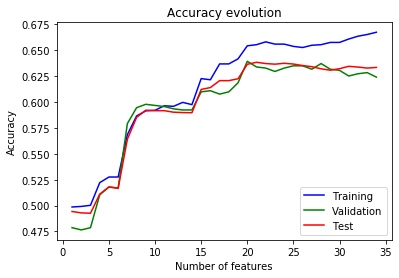

Number optimum of features: 20
The optimum test accuracy is  63.64%


In [31]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Define the range of features to explore
# (explore the 1000 most relevant ones, starting with 5 and using[:,ind_rel_feat]steps of 10 features)
rang_feat = np.arange(1, 35, 1) 
print(rang_feat)
#[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(#<FILL IN>)
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(X_train[:,ind_rel_feat], Y_train, X_val[:,ind_rel_feat], Y_val, X_test[:,ind_rel_feat], Y_test, rang_feat)

# Plot the results
plt.figure()
plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test)
plt.show()

# Find the optimum number of features
num_opt_feat = np.argmax(acc_val)+1#<FILL IN>
test_acc_opt = acc_test[np.argmax(acc_val)]#<FILL IN>

print('Number optimum of features: ' + str(num_opt_feat))
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))

### ** Part 1.2: Mutual Information **


Compute the MI between each input feature and the output labes to measure the relevance of each feature. Check the function [mutual_info_classif()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif).

Note: this MI estimator has a parameter (n_neighbors) which should be validated. You can use its default value for this experiment.

In [32]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
from sklearn.feature_selection import mutual_info_classif

# Obtain MI values
#MI = mutual_info_classif(#<FILL IN>, random_state =0)  # Returns MI values
MI = mutual_info_classif(X_train,Y_train, random_state =0)  # Returns MI values
    
# sort in descending order
#ind_rel_feat = # <FILL IN>
ind_rel_feat =  np.argsort(-1*MI)     
# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, ind_rel_feat[f], MI[ind_rel_feat[f]]))

Feature ranking:
1. feature 10 (0.485317)
2. feature 9 (0.458229)
3. feature 5 (0.437190)
4. feature 0 (0.435074)
5. feature 3 (0.382249)
6. feature 6 (0.360257)
7. feature 4 (0.326502)
8. feature 1 (0.296623)
9. feature 2 (0.286344)
10. feature 25 (0.195716)


Now, use the above the result to:
* Evaluate the linear SVM performance with the most relevant features are used (use SVM_accuracy_evolution( ) function). Plot the evolution of the training, validation and test accuracies.
* Obtain, using the validation accuracy, the optimum number of features to use.
* Create the mask with the selected features and plot it (you can use the plot_image( ) function).

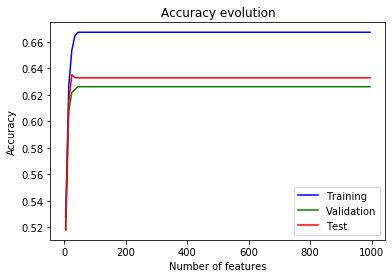

Number optimum of features: 5
The optimum test accuracy is  63.29%


In [35]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Define the range of features to explore
# (explore the 1000 most relevant ones, starting with 5 and usings steps of 10 features)
rang_feat = np.arange(5, 1000, 10) 
#[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(#<FILL IN>)
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(X_train[:,ind_rel_feat], Y_train, X_val[:,ind_rel_feat], Y_val, X_test[:,ind_rel_feat], Y_test, rang_feat)


# Plot the results
plt.figure()
plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test)
plt.show()

# Find the optimum number of features
num_opt_feat = np.argmax(acc_val)+1#<FILL IN>
test_acc_opt = acc_test[np.argmax(acc_val)]#<FILL IN>

print('Number optimum of features: ' + str(num_opt_feat))
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))
    


### ** Part 1.3: Random Forest **

Train a random forest to obtain a measurement of the relevance of each feature. You can use the  [RandomForestClassifier()](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) function, which returns the feature relevances in the variable .feature\_importances\_.


Complete the following code to:
* Train a random forest classifier with the parameters given by default and 250 trees.
* Use the forest feature importances to obtain a ranking with the most relevant features, save their positions in the variable  ind\_rel\_feat

In [36]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
from sklearn.ensemble import RandomForestClassifier
np.random.seed(1)
# Build a forest and obtain the feature importances
forest = RandomForestClassifier(n_estimators=250)
forest.fit(X_train, Y_train)
importances = forest.feature_importances_# <FILL IN>

# Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat =  np.argsort(-1*importances) # <FILL IN>

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, ind_rel_feat[f], importances[ind_rel_feat[f]]))

Feature ranking:
1. feature 6 (0.063861)
2. feature 10 (0.054929)
3. feature 9 (0.052477)
4. feature 22 (0.052220)
5. feature 0 (0.049510)
6. feature 36 (0.045140)
7. feature 5 (0.043588)
8. feature 19 (0.039885)
9. feature 25 (0.038161)
10. feature 13 (0.037061)


Now, use the above the result to:
* Evaluate the linear SVM performance with the most relevant features are used (use SVM_accuracy_evolution( ) function). Plot the evolution of the training, validation and test accuracies.
* Obtain, using the validation accuracy, the optimum number of features to use.
* Create the mask with the selected features and plot it (you can use the plot_image( ) function).

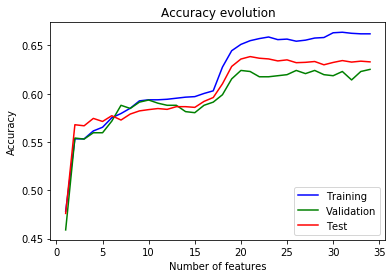

Number optimum of features: 34
The optimum test accuracy is  63.29%


In [38]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Define the range of features to explore
# (explore the 1000 most relevant ones, starting with 5 and usings steps of 10 features)
rang_feat = np.arange(1, 35, 1) # To speed up the execution, we use steps of 10 features.
#[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(#<FILL IN>)
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(X_train[:,ind_rel_feat], Y_train, X_val[:,ind_rel_feat], Y_val, X_test[:,ind_rel_feat], Y_test, rang_feat)

# Plot it!
plt.figure()
plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test)
plt.show()

# Find the optimum number of features
num_opt_feat = np.argmax(acc_val)+1#<FILL IN>
test_acc_opt = acc_test[np.argmax(acc_val)]#<FILL IN>


print('Number optimum of features: ' + str(num_opt_feat))
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))

    

# Part 1: Wrapers for feature selection: RFE

The Recursive Feature Elimination (RFE) method iteratively trains a set of SVM classifier and, in each step, it eliminates a feature (or a subset of features) in such a way that the classification margin is reduced the least.

Scikit-Learn provides a function with a full implementation of the RFE method. This function, [RFE( )](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), let user select the classifier to consider, the number of selected features (parameter n\_features\_to\_select) and the number of features removed in each step (parameter step).  As result, in parameter .ranking returns the ranking position of the each feature (i.e., .ranking\_[i] corresponds to the ranking position of the i-th feature).

Complete the following code to:
* Train the RFE approach with a linear SVM fixing  n_features_to_select to 10 (so that we run the RFE method until the end obtaining a full raking with all the features) and step to 10 (just to speed up the training).
* Use the content of .ranking\_ to obtain a ranking with the most relevant features, save their positions in the variable  ind\_rel\_feat.


In [45]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

print('The training of this method can take some minutes, be patient...')
# Define the classifier, the RFE method and train it
estimator = SVC(kernel="linear")
RFE_selector = RFE(estimator, 1, step=1)
RFE_selector.fit(X_train, Y_train)

# Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat = np.argsort(RFE_selector.ranking_)

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d" % (f + 1, ind_rel_feat[f]))

The training of this method can take some minutes, be patient...
Feature ranking:
1. feature 10
2. feature 16
3. feature 6
4. feature 36
5. feature 5
6. feature 25
7. feature 2
8. feature 0
9. feature 4
10. feature 20


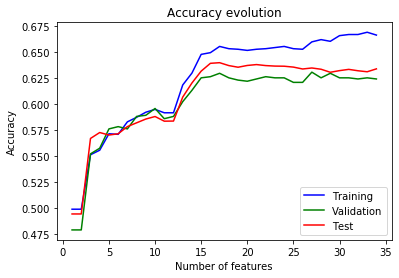

Number optimum of features: 27
The optimum test accuracy is  63.46%


In [46]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
# Define the range of features to explore
# (explore the 1000 most relevant ones, starting with 5 and usings steps of 10 features)
rang_feat = np.arange(1, 35, 1) # To speed up the execution, we use steps of 10 features.
#[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(#<FILL IN>)
[acc_tr, acc_val, acc_test] = SVM_accuracy_evolution(X_train[:,ind_rel_feat], Y_train, X_val[:,ind_rel_feat], Y_val, X_test[:,ind_rel_feat], Y_test, rang_feat)

# Plot it!
plt.figure()
plot_accuracy_evolution(rang_feat, acc_tr, acc_val, acc_test)
plt.show()

# Find the optimum number of features
num_opt_feat = np.argmax(acc_val)+1#<FILL IN>
test_acc_opt = acc_test[np.argmax(acc_val)]#<FILL IN>


print('Number optimum of features: ' + str(num_opt_feat))
print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))

## ** Part 2: Embedded methods:  L1 regularization**

Embedded methods are able to carry out the feature selection process during the classifier training, so both stages (feature selection and classifier training) are completely linked and, therefore, the selection process is guided by the classifier.

In this case, we are going to study two well-known techniques:  
* L1 SVM: in this case we can train linear SVM regularized with a L1 penalty which is able to provide sparsity over the weight vector. As to obtain the classifier output we have to multiply the input data by this vector, those input features associated to the zeros of the weight vector are not used during the classification process (at least, in binary problem, we later analyze this in detail for the multiclass case). 

* L1 Logistic Regression: here, we will apply the above L1 penalty, but using a Logistic Regression classifier.

### ** Part 2.1: L1-SVM**

In this last section, we are going to analyze the properties of the L1-SVM as feature selection approach. For this purpose, we are going to use the linear SVM implementation given by the method LinearSVC, which directly let us select the regularization to be used.

Unlike previous methods, here we cannot obtain a ranking of variables. In this case, we have to sweep the value of the regularization parameter in order to get a higher (or lower) sparsity of the weight vector. According to this, complete the following code to:
* Train a linear l1-SVM for different values of the regularization parameter, for each value obtain the training, validation and test accuracies, as well as the sparsity rate. Sparsity Rate (SR) is defined as the mean number of zeros of the SVM weight vector (check the parameter .coef\_ of the SVM classifier), then, if all elements are zero, SR has to be 100%.
* Plot the resulting accuracy curves.
* Finally, analyzing the validation accuracy, select the optimum value of C.

Note:  As we are working with a multiclass problem (1 vs all scheme), we are going to obtain a set of vectors (one for each binary problem). We could define different approaches to work with this set of vectors, however, for the sake of simplicity, in this first exercise, let's compute the multiclass SR by averaging the SR of each vector.

The training of this method can take some minutes, be patient...


/home/roberto.diaz/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/roberto.diaz/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/roberto.diaz/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/roberto.diaz/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/roberto.diaz/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increa

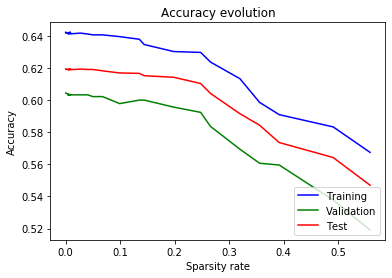

In [52]:
###########################################################
# TODO: Replace <FILL IN> with appropriate code
###########################################################
from sklearn.svm import LinearSVC
np.random.seed(1)
# Defining some useful variables to save results
acc_tr = []
acc_val = []
acc_test = []
sparsity_rate = []

# Defining the range of C values to explore
rang_C = 2*np.logspace(-2, 2, 20)

print('The training of this method can take some minutes, be patient...')
for i, C in enumerate(rang_C):
    # Define and train SVM classifier
    svm_l1 = LinearSVC(C=C, penalty="l1", dual=False)
    svm_l1.fit(X_train, Y_train)
    
    # Compute the sparsity rate (coef_l1 contains zeros due to the
    # L1 sparsity inducing norm)
    sparsity_rate.append((np.float_(np.size(svm_l1.coef_))-np.count_nonzero(svm_l1.coef_))/np.size(svm_l1.coef_))
    
    # Compute accuracies
    acc_tr.append(svm_l1.score(X_train, Y_train))
    acc_val.append(svm_l1.score(X_val, Y_val))
    acc_test.append(svm_l1.score(X_test, Y_test))

    
# Plot the accuracy curves
plt.figure()
plot_accuracy_evolution(sparsity_rate, acc_tr, acc_val, acc_test)
plt.xlabel("Sparsity rate")
plt.show()

# Find the optimum value of C
#C_opt = # <FILL IN>
#test_acc_opt = # <FILL IN>

#print 'Optimum value of C: ' + str(C_opt)
#print("The optimum test accuracy is  %2.2f%%" %(100*test_acc_opt))
